In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210326-143448.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-204040.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-204543.txt")
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210410-205042.txt")
sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210421-145843.txt")

In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np
from gyrii.underpinnings.BayesianArray import BayesianArray

class MotionCalibGyrus(Gyrus):
    def __init__(self):
        self.last_pose=None
        self.last_pose_covariance=None        
        self.pose_history=[] #time, pose
        self.motor_history=[] # starttime, endtime, activity
        self.last_motor_activity=[]
        self.last_motor_activity_timestamp=[]
        
    def same_pose(self,a,b,x_thresh,t_thresh):
        delta=np.array(a)-np.array(b)
        if abs(delta[2])>t_thresh:
            return False
        dx=np.sqrt(delta[0]**2+delta[1]**2)
        if dx>x_thresh:
            return False
        return True
    
    def bracket_history(self):
        ret=[]
        pose_h=np.array(self.pose_history)
        motor_h=np.array(self.motor_history)
        indices_before=np.searchsorted(pose_h[:,0],motor_h[:,0])-1
        indices_after=np.searchsorted(pose_h[:,0],motor_h[:,0]+motor_h[:,2])
        #print(indices_before)
        valid1= indices_before>=0 
        valid2= indices_after<len(pose_h)
        #print(valid)
        indices_before=indices_before[valid1 & valid2]
        indices_after=indices_after[valid1 & valid2]
        motor_h=motor_h[valid1 & valid2]
        
        for i in range(len(motor_h)):
            obj={"pose_before": pose_h[indices_before[i]], "pose_after": pose_h[indices_after[i]], "motor_usage": motor_h[i]}
            ret.append(obj)
        return ret
    
    def history_to_training_points(self):
        xs=[] #motor activation times duration
        ys=[] #change in pose        
        rs=[] #facing matrix
        bh=self.bracket_history()
        for i in range(len(bh)):
            delta_pose=bh[i]["pose_after"][1]-bh[i]["pose_before"][1]
            delta_pose.vals[2]=(delta_pose.vals[2]+np.pi)%(2*np.pi)-np.pi
            usage_times_dur=bh[i]["motor_usage"][2]*np.array(bh[i]["motor_usage"][1])
            ys.append(delta_pose.vals)
            xs.append(usage_times_dur)
            #print("angle {}".format(bh[i]["pose_before"][1].vals[2]))
            r=self.to_facing_matrix(bh[i]["pose_before"][1].vals[2])
            #print("rot mat {}".format(r))
            rs.append(np.array(r))
        return xs,ys,rs
    
    def to_facing_matrix(self,angle):
        return np.array([[np.cos(angle),np.sin(angle),0],
                     [-np.sin(angle),np.cos(angle),0],
                     [0,0,1]]) #did I get the sign right?
    
    def calibrate_fbs(self,fbs):
        x=[ fb[2][2] for fb in fbs ]

    def read_message(self,message):
        if "latest_pose" in message:
            the_pose=BayesianArray.from_object(message["latest_pose"])
            if message["pose_notes"]=="pose_is_stable":
                if len(self.pose_history)==0 or not self.same_pose(self.pose_history[-1][1].vals,the_pose.vals,0.02,0.02):
                    self.pose_history.append([message["timestamp"],the_pose]) #save to recent history for fitting
            self.last_pose=np.array(message["latest_pose"]["vals"])
            self.last_pose_covariance=np.array(message["latest_pose"]["covariance"])
        if "drive/motors_active" in message:
            motors_active=message["drive/motors_active"][0:3]
            duration=message["drive/motors_active"][3]
            if motors_active!=[0,0,0]:
                if motors_active==self.last_motor_activity:
                    self.motor_history[-1][2]+=duration                    
                else:
                    self.motor_history.append( [ message["timestamp"],message["drive/motors_active"][0:3],duration])            
            self.last_motor_activity=motors_active            
            self.last_motor_activity_timestamp=message["timestamp"]
        return []


class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Position Uncertainty (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Position Uncertainty (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.lx_dataseries=TimeSeries(title="Pose X",ylabel="X Position Lidar (m)")
        self.lx_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ly_dataseries=TimeSeries(title="Pose Y",ylabel="X Position Lidar (m)")
        self.ly_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Lidar Position Uncertainty (m)")
        self.ltheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ltheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        self.ctheta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.ctheta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")   
        self.motor_durations=TimeSeries(title="Motor Duration")
        self.bfield_times=[]
        self.bfields=[]
        
        
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            if message["pose_notes"]!="pose_is_stable":
                return
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.x_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][0][0]))
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.y_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][1][1]))
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="lidar":
            self.lx_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][0])
            self.lx_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][0][0]))
            self.ly_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][1])
            self.ly_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][1][1]))
            self.ltheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ltheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "notes" in message and message["notes"]=="compass":
            self.ctheta_dataseries.append(message["timestamp"],message["pose_measurement"]["vals"][2])
            self.ctheta_unc_dataseries.append(message["timestamp"],np.sqrt(message["pose_measurement"]["covariance"][2][2]))
        if "magnetometer/b_field" in message:
            self.bfield_times.append(message["timestamp"])
            self.bfields.append(np.array(message["magnetometer/b_field"])    )  
        if "drive/motors_active" in message:
            if message["drive/motors_active"][3]< 100:
                self.motor_durations.append(message["timestamp"],message["drive/motors_active"][3])

        return []


In [3]:
from MotionGyrus import MotionEstimationGyrus

plotters={}
plotters["pose"]=PosePlotter()

gyrii=[]
#gyrii.append(MotionEstimationGyrus(None))
mcgyrus=MotionCalibGyrus()
gyrii.append(mcgyrus)

for key in plotters:
    gyrii.append(plotters[key])

start_timestamp=sensor_log[0]["timestamp"]
inspect_messagename="none"

remove_messages=["po"]

for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                      
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            resp=g.read_message(on_message)
            if resp is not None:
                waiting_messages.extend(resp)

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


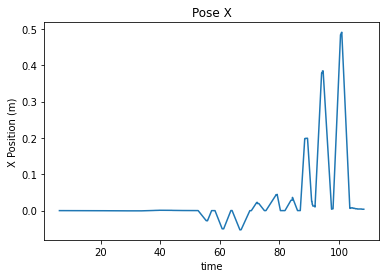

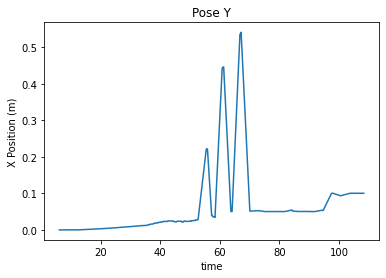

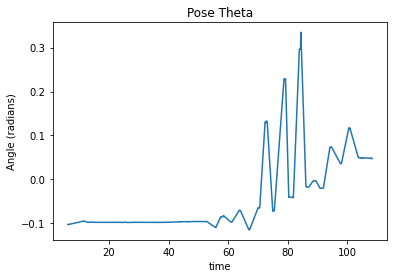

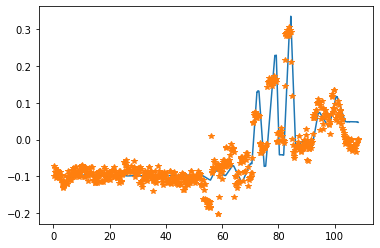

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


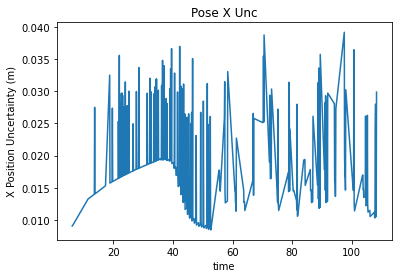

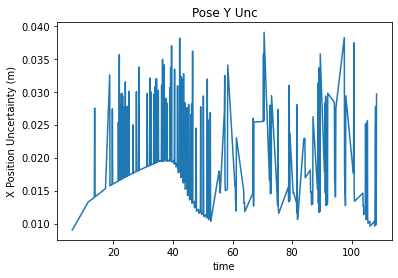

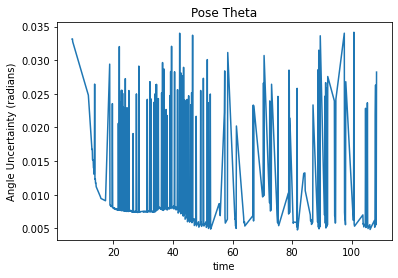

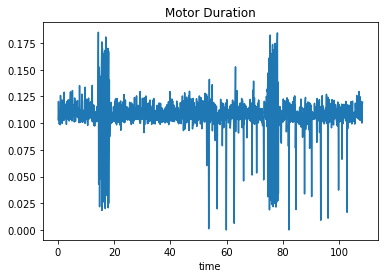

In [4]:
import matplotlib.pyplot as plt
plotters["pose"].x_dataseries.plot()
plotters["pose"].y_dataseries.plot()
plotters["pose"].theta_dataseries.plot()
plt.figure()
#plt.xlim(10,14)
plt.plot(plotters["pose"].theta_dataseries.times,plotters["pose"].theta_dataseries.data)
plt.plot(plotters["pose"].ctheta_dataseries.times,plotters["pose"].ctheta_dataseries.data,'*')
plt.show()
plotters["pose"].x_unc_dataseries.plot()
plotters["pose"].y_unc_dataseries.plot()
plotters["pose"].theta_unc_dataseries.plot()

plotters["pose"].motor_durations.plot()

In [5]:
from uncertainties import unumpy
from uncertainties import ufloat

print(len(mcgyrus.pose_history))
print(len(mcgyrus.motor_history))

def fit_slope(xs,ys,sigmasquares,m_prior,m_prior_unc):
    #given motion records and a single dimension, fit to y=m*x
    #returns best fit m, m_unc, chi-square/n
    xxsum=0
    xysum=0
    yysum=0
    prior_uncsquare=m_prior_unc**2
    #print("prior is {}".format(ufloat(m_prior,m_prior_unc)))

    for i in range(len(xs)):
        x=xs[i]
        y=ys[i]
        sigmasquare=sigmasquares[i]
        xxsum+=x*x/sigmasquare
        xysum+=x*y/sigmasquare
        yysum+=y*y/sigmasquare
    myslope=(xysum+m_prior/prior_uncsquare)/(xxsum+1/prior_uncsquare)
    #print("myslope is {}".format(myslope))
    myslope_unc=np.sqrt(1/(xxsum/sigmasquare+1/prior_uncsquare))
    #print("myslope  unc is {}".format(myslope_unc))
    chisq=myslope*myslope*xxsum-2*myslope*xysum+yysum
    chisq=chisq/len(xs)
    if chisq>1: #inflate uncertainties if I'm underestimating error bars on data
        myslope_unc*=np.sqrt(chisq)
    return myslope,myslope_unc,chisq


21
18


i 0 j 0
slope -0.010905083025312259 unc 0.022979555068788262 chisq 0.8874572183575327


<ipython-input-2-57a3dc32cc04>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  motor_h=np.array(self.motor_history)
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

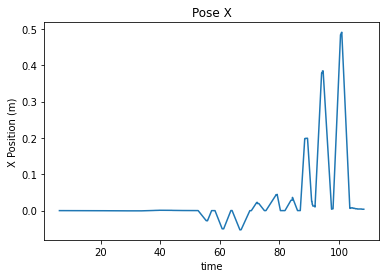

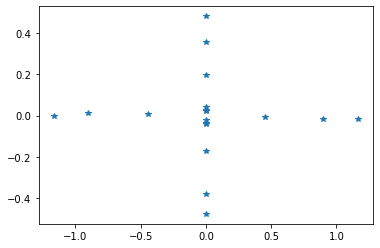

i 0 j 1
slope 0.4275221822308553 unc 0.022979555068788262 chisq 0.004690871032571782


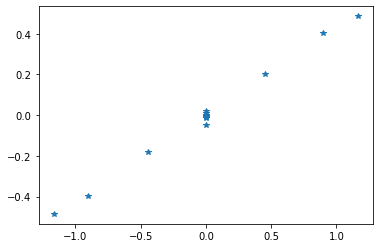

i 0 j 2
slope -0.031584849339916635 unc 0.022979555068788262 chisq 0.5571887471206631


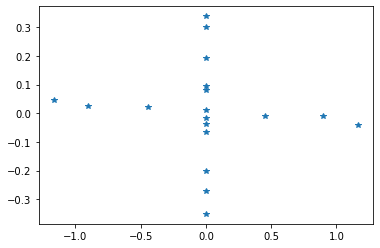

i 1 j 0
slope 0.4099548433913896 unc 0.023043412762559647 chisq 0.008724600101201772


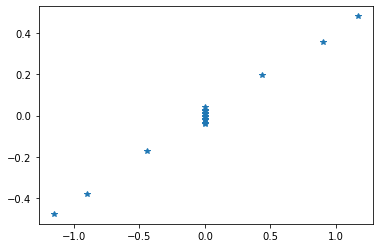

i 1 j 1
slope 0.010073956421179319 unc 0.023043412762559647 chisq 0.9658186612958359


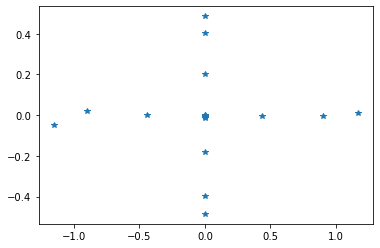

i 1 j 2
slope 0.06372919658870145 unc 0.023043412762559647 chisq 0.5411869862466246


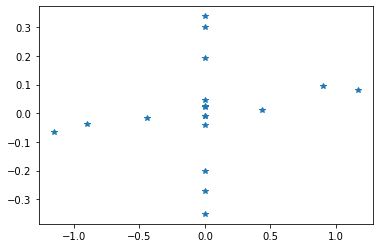

i 2 j 0
slope -0.33484511342154527 unc 0.21537893188267304 chisq 0.8812474834277295


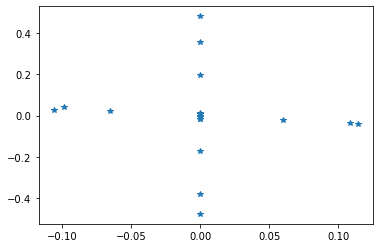

i 2 j 1
slope -0.05031160260931942 unc 0.21537893188267304 chisq 0.9661953434947687


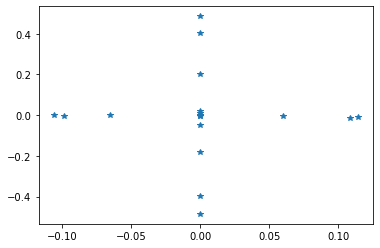

i 2 j 2
slope -2.9349442673677935 unc 0.21537893188267304 chisq 0.037294626995142285


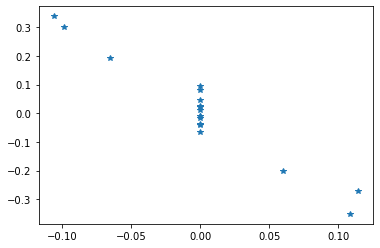

In [12]:
#ret=mcgyrus.bracket_history()
#my hypothesis is that    y= R^-1 M R x
xs,ys,rs=mcgyrus.history_to_training_points()

#xprimes=np.array([ np.dot(r,x) for r,x in zip(rs,xs) ])
xprimes=np.array([ x for x in xs])
yprimes=np.array([ np.dot(r.T,y) for r,y in zip(rs,ys) ])


#yprime=np.dot(rs,ys)
#print(xprimes)
#print(yprimes)

plt.figure()
plotters["pose"].x_dataseries.plot()
plt.show

mat_vals=[]
imat_vals=[]
for i in range(3):
    for j in range(3):
        slope,unc,chisq=fit_slope(xprimes[:,i],yprimes[:,j],0.05*np.ones(len(xprimes[:,i])),0,10)
        mat_vals.append(slope)
        print("i {} j {}".format(i,j))
        print("slope {} unc {} chisq {}".format(slope,unc,chisq))
        plt.figure()
        plt.plot(xprimes[:,i],yprimes[:,j],'*')
        plt.show()
        slope2,unc2,chisq2=fit_slope(yprimes[:,j],xprimes[:,i],0.05*np.ones(len(xprimes[:,i])),0,10)
        imat_vals.append(ufloat(slope2,unc2))
        

    


#for x,y in zip(xs,ys):    
    #print("velocity {}".format(y[2]/x[2]))
    #print("{} {} - {} {}".format(bh[i]["pose_before"][0],bh[i]["pose_before"][1].pretty_str(),bh[i]["motor_usage"],bh[i]["pose_after"]))
    #print("{} {}-{} {}".format(bh[i][0][0],bh[i][2][0],bh[i][2][1],bh[i][1][0]))

In [29]:
from scipy.linalg import pinv
slope_offset_matrix=np.reshape(mat_vals,(3,3))
print("Final Matrix {}".format(slope_offset_matrix))
#print("Inverse Matrix {}".format(pinv(slope_offset_matrix)))
#mymat=np.reshape(imat_vals,(3,3))
for i in range(3):
    for j in range(3):
        print("{}, {} = {}".format(i,j,slope_offset_matrix[i,j]))
#print("Forward Matrix {}".format(np.reshape(imat_vals,(3,3))))
          

Final Matrix [[-0.01090508  0.42752218 -0.03158485]
 [ 0.40995484  0.01007396  0.0637292 ]
 [-0.33484511 -0.0503116  -2.93494427]]
0, 0 = -0.010905083025312259
0, 1 = 0.4275221822308553
0, 2 = -0.031584849339916635
1, 0 = 0.4099548433913896
1, 1 = 0.010073956421179319
1, 2 = 0.06372919658870145
2, 0 = -0.33484511342154527
2, 1 = -0.05031160260931942
2, 2 = -2.9349442673677935


In [30]:
from scipy.optimize import least_squares
from scipy.linalg import pinv
from uncertainties import ufloat,unumpy
def resid_func(params,*args,**kwargs):
    xs=kwargs["xs"]
    ys=kwargs["ys"]
    rs=kwargs["rs"]
    mat=np.reshape(params,(3,3))
    ret=[]
    for x,y,r in zip(xs,ys,rs):
        resids=(y-np.dot(mat,x))/0.05
        ret.extend(resids)
        #print("resids {}".format(resids))
    print("chisq {}".format(np.dot(ret,ret)))
    return ret                       

#x0=[0,1,0,1,0,0,0,0,1]
#x0=unumpy.nominal_values(imat_vals)
x0=mat_vals
ret=least_squares(resid_func,x0,kwargs={"xs":xprimes,"ys":yprimes,"rs":rs})
#print(ret)
hessian=np.dot(ret.jac.T,ret.jac)
#print(hessian)
cov=pinv(hessian)
for i in range(9):
    #print("val {} is {}".format(i,ret.x[i]))
    print("val {} is {}".format(i,ufloat(ret.x[i],np.sqrt(cov[i][i]))))

    

chisq 207.9035661750304
chisq 207.90356617496585
chisq 207.90356715854932
chisq 207.90356597829347
chisq 207.90356518103317
chisq 207.90356617497076
chisq 207.90356624856256
chisq 207.90358328996822
chisq 207.90357257591887
chisq 207.90356612368763
chisq 5.766925246168082
chisq 5.766925246168503
chisq 5.7669252461685
chisq 5.766925246168087
chisq 5.766925246168504
chisq 5.7669252461685
chisq 5.766925246168086
chisq 5.766925246168491
chisq 5.766925246168505
chisq 5.766925246168126
chisq 5.766925246168083
val 0 is -0.011+/-0.023
val 1 is 0.410+/-0.023
val 2 is -0.34+/-0.22
val 3 is 0.428+/-0.023
val 4 is 0.010+/-0.023
val 5 is -0.05+/-0.22
val 6 is -0.032+/-0.023
val 7 is 0.064+/-0.023
val 8 is -2.96+/-0.22
